In [2]:
from llama_cpp import Llama
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import torch
from torch.nn import functional as F

In [3]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/llama/converted/llama_13b_ggml_q4_3.bin"
lora_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/SuperCOT-LoRA/13b/ggml/cutoff-2048/ggml-adapter-model.bin"

LLM = Llama(model_path=model_bin, lora_path=lora_bin, n_ctx=2048, n_threads=7, use_mmap=False, n_batch=512)

llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/llama/converted/llama_13b_ggml_q4_3.bin
llama_model_load_internal: format     = ggjt v1 (latest)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 5120
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 40
llama_model_load_internal: n_layer    = 40
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 6 (mostly Q4_3)
llama_model_load_internal: n_ff       = 13824
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 13B
llama_model_load_internal: ggml ctx size = 9534493.73 KB
llama_model_load_internal: mem required  = 11359.03 MB (+ 1608.00 MB per state)
....................................................................................................
llama_init_from_file: kv self size  = 1600.00 MB
llama_apply_lora_fro

In [4]:
prompt = """### Instruction:
Randomly name a fantasy race. Be creative. Answer succinctly.

### Response:
"""

tokens = LLM.tokenize(prompt.encode('utf-8'))

In [5]:
LLM.reset()
LLM.eval(tokens)

In [6]:
logits = LLM._logits()
print('Logits are {}x{}'.format(len(logits), len(logits[0])))
logits = np.array(logits[0])
probs=F.softmax(torch.from_numpy(logits)).numpy()

Logits are 1x32000


/tmp/ipykernel_1021490/3317383468.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


Text(0.5, 1.0, 'Histogram of logits')

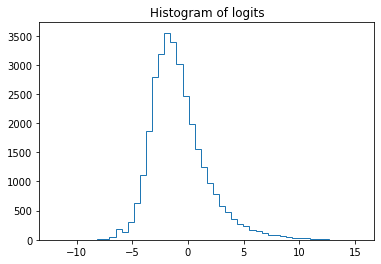

In [7]:
counts, bins = np.histogram(logits, bins=50)
plt.stairs(counts, bins)
plt.title('Histogram of logits')

(32000,)
There are 220 tokens outside the smallest bin.


Text(0.5, 1.0, 'Histogram of Token Probabilities')

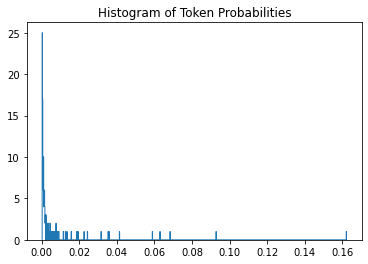

In [8]:
print(probs.shape)
counts, bins = np.histogram(probs, bins=1000)
# Observing that the vast majority of tokens are in the first bin, i.e. have incredibly small probability.
print('There are {} tokens outside the smallest bin.'.format(len(np.where(probs>bins[1])[0])))
# Don't plot the smallest bins since they are not interesting and dwarf all other bins
plt.stairs(counts[2:], bins[2:])
plt.title('Histogram of Token Probabilities')

Text(0.5, 1.0, 'Bar chart of 10 most likely tokens')

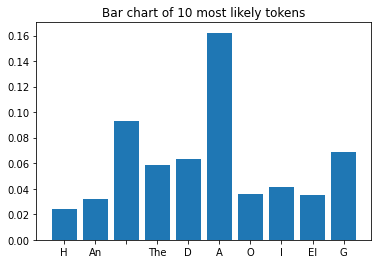

In [9]:
# Let's see the most likely tokens:
num_tokens_to_plot = 10
ind = np.argpartition(probs, -num_tokens_to_plot)[-num_tokens_to_plot:]

likely_tokens = []
token_probs = []

for token in ind:
    c_token = [(ctypes.c_int)(*[token])]
    # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
    likely_tokens.append(LLM.detokenize(c_token))
    token_probs.append(probs[token])

plt.bar(likely_tokens, token_probs)
plt.title('Bar chart of 10 most likely tokens')